In [1]:
# import tensorflow as tf
# tf.test.is_built_with_cuda()

In [2]:
import os
import math
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH = 'Data/genres_original'
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
num_mfcc=13
n_fft=2048
hop_length=512
num_segments = 10
samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

In [5]:
cd ..

/Users/joditan/Documents/GitHub/music-genre-classification


In [6]:
os. getcwd()

'/Users/joditan/Documents/GitHub/music-genre-classification'

In [19]:
DATASET_PATH = 'Data/genres_original'
JSON_PATH = "RNNLSTM/info.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)


    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        if dirpath is not dataset_path:

            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            for f in filenames:

                file_path = os.path.join(dirpath, f)
            
                if file_path != 'Data/genres_original/jazz/jazz.00054.wav':

                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                
                    for d in range(num_segments):
                        start = samples_per_segment * d
                        finish = start + samples_per_segment
                        mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print("{}, segment:{}".format(file_path, d+1))

    
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=6)

In [7]:
import json

DATA_PATH = "RNNLSTM/info.json"

def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z


def plot_history(history):

    fig, axs = plt.subplots(2)


    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):

    # load data
    X, y, z = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z


**using parallel cnn rnn model**

In [8]:
def build_model(input_shape):
    
    model = keras.Sequential()

    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

def predict(model, X, y):
    
    X = X[np.newaxis, ...] 

    
    prediction = model.predict(X)

    
    predicted_index = np.argmax(prediction, axis=1)
    
    
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 214, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 107, 6, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 107, 6, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 105, 4, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 53, 2, 32)         128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 1, 32)         4

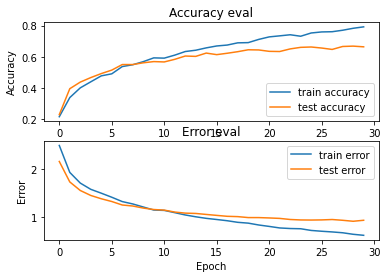

1498/1 - 5s - loss: 0.8627 - accuracy: 0.6562

Test accuracy: 0.6562083


In [9]:
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.25, 0.2)


input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)


optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)


plot_history(history)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [11]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

predict(model, X_test[1], y_test[1])

Expected index: 3, Predicted index: [3]


**using rnn model**

In [25]:
def build_model_2(input_shape):
    
    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [32]:
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.25, 0.2)
print(X_train.shape[1], X_train.shape[2])

216 13


In [48]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
print(X_train.shape)
print(X_test.shape)


(3595, 216, 13)


[[[-1.53306854e+00  4.86996384e+01  5.93491325e+01 ... -4.07051706e+00
    6.35295391e+00  2.11519659e-01]
  [ 3.86365204e+01  3.63592567e+01  5.31226730e+01 ... -6.32592010e+00
    5.74560070e+00  2.46331310e+00]
  [ 1.56511898e+01  3.63049011e+01  4.52547417e+01 ... -4.97560835e+00
    6.22802353e+00  7.15034580e+00]
  ...
  [ 6.42324448e+01  4.27398872e+01 -6.78348303e+00 ... -6.81175232e+00
   -1.01023817e+01  8.08573008e-01]
  [ 1.44055206e+02  3.88709793e+01 -1.05162592e+01 ... -5.13120604e+00
   -7.89645100e+00 -7.64211595e-01]
  [ 1.34362152e+02  3.86356812e+01 -6.29030418e+00 ...  1.76055878e-01
   -2.18230009e+00  2.31312037e-01]]

 [[-2.07514023e+02  1.62000244e+02 -4.39146729e+01 ... -2.06451855e+01
   -8.92510796e+00 -1.50614815e+01]
  [-1.87435577e+02  1.53680817e+02 -4.88663940e+01 ... -2.92156029e+01
   -1.19803190e+01 -2.55397682e+01]
  [-2.10764282e+02  1.48434448e+02 -4.44777908e+01 ... -3.12230911e+01
   -1.29975662e+01 -3.30677872e+01]
  ...
  [-2.70533264e+02  1.5

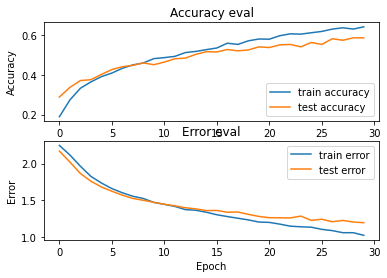

1498/1 - 20s - loss: 1.0608 - accuracy: 0.5821

Test accuracy: 0.58210945


In [53]:
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.25, 0.2)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], -1)

print(X_test, X_train, X_validation)

input_shape_2 = (X_train.shape[1], X_train.shape[2])
#X_train = (len(X_train), 1, X_train.shape[1])
model_2 = build_model_2(input_shape_2)


optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_2.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_2.summary()


history = model_2.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

plot_history(history)

test_loss, test_acc = model_2.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)